In [48]:
import numpy as np
import math
import matplotlib.pyplot as plt

# basic functions

def nCr(n,r):
    f = math.factorial
    return f(n) // f(r) // f(n-r)

def catTriangle(w,l):
    return int(math.factorial(w+l)*(w+-l+1)/(math.factorial(l)*math.factorial(w+1)))

def catTrapezoid(w,l,m):
    if 0 <= l < m:
        return nCr(w + l, l)
    elif m <= l <= w + m -1:
        return nCr(w+l,l) - nCr(w+l,l-m)
    else:
        return 0

dp = {}
def catTrapezoidWeighted(w,l,m,a,b):
    f = (w,l,m,a,b)
    if f in dp:
        return dp[f]
    if l == 0:
        return 1
    elif b*l >= a*w + m:
        return 0
    elif w == 0:
        return 1
    else:
        val = catTrapezoidWeighted(w-1,l,m,a,b) + catTrapezoidWeighted(w,l-1,m,a,b)
        dp[f] = val
        return dp[f]
    
dp2 = {}
def catTrapezoidWeightedInverse(x,w,l,p,q,c):
    f = (x,w,l,p,q,c)
    if f in dp2:
        return dp2[f]
    else:
        x_new = x_update(x,w,l,p,q)
        if local_reward(x_new,p,q,c) < 0:
            dp2[f] = 0
            return dp2[f]
        elif w == 0 and l == 0:
            dp2[f] = 1
            return dp2[f]
        elif l == 0:
            dp2[f] = catTrapezoidWeightedInverse(x,w-1,l,p,q,c)
            return dp2[f]
        elif w == 0:
            dp2[f] = catTrapezoidWeightedInverse(x,w,l-1,p,q,c)
            return dp2[f]
        else:
            dp2[f] = catTrapezoidWeightedInverse(x,w-1,l,p,q,c) + catTrapezoidWeightedInverse(x,w,l-1,p,q,c)
            return dp2[f]

def getAB(p,q,x):
    a = math.log(p/q)
    b = math.log((1-q)/(1-p))

    return (a/b).as_integer_ratio()
        
def update_prior(x,p,q,result):
    if result == True:
        return p*x/(win(x,p,q))
    else:
        return (1 - p)*x/(lose(x,p,q))

def prior_inverse(x,p,q,result):
    if result == True:
        return x*q/(p - x*p + x*q)
    else:
        return x*(1-q)/( (1-p) - x*(1-p) + x*(1-q))

def local_reward(x,p,q,c):
    out = win(x,p,q) - c
    return out

def win(x,p,q):
    return x*p + (1-x)*q

def lose(x,p,q):
    return x*(1-p) + (1-x)*(1-q)

def x_update(x,w,l,p,q):
    return  (x*p**w*(1-p)**l)/(x*p**w*(1-p)**l + (1-x)*q**w*(1-q)**l)

def expected_profit(x,p,q,c,c2,delta,rounds=100):
    
    if c < c2 or local_reward(x,p,q,c) < 0:
        return 0
    tot = 0
    
    # first, get possible losses
    possibleLosses = 0
    x_new = x
    while local_reward(x_new,p,q,c) >= 0 and possibleLosses < 40:
        possibleLosses += 1
#         print(x_new, local_reward(x_new,p,q,c))
        x_new = update_prior(x_new,p,q,False)
    possibleLosses -= 1
    
    for t in range(rounds):
        lowest = max(0,int((t-possibleLosses+1)/2)-1)
            
        for w in range(lowest,t + 1,1):
            l = t - w
            paths = catTrapezoid(w,l,possibleLosses+1)
#             print(f"t: {t}, w: {w}, l: {l}, paths: {paths}")
            if paths > 0 or l == 0:
                tot += delta**t*(c - c2)*paths*prob_reach(x,w,l,p,q)
            elif paths == 0 and catTrapezoid(w,l-1,possibleLosses+1) > 0:
#                 print('got here')
                tot += delta**t*(win(x,p,q) - c2)*catTrapezoid(w,l-1,possibleLosses+1)*prob_reach(x,w,l-1,p,q)*lose(x_update(x,w,l-1,p,q),p,q)
                
    return tot

def expected_profit_weighted(x,p,q,c,c2,delta,rounds=100):
    
    if c < c2 or local_reward(x,p,q,c) < 0:
        return 0
    
    tot = 0

    for t in range(rounds):
        lowest = 0
            
        for w in range(lowest,t + 1,1):
            l = t - w
            paths = catTrapezoidWeightedInverse(x,w,l,p,q,c)
#             print(f"t: {t}, w: {w}, l: {l}, paths: {paths}")
            if paths > 0 or l == 0:
                tot += delta**t*(c - c2)*paths*prob_reach(x,w,l,p,q)
            elif paths == 0 and catTrapezoidWeightedInverse(x,w,l-1,p,q,c) > 0: # final loss
#                 print('got here',delta**t*(c - c2)*catTrapezoidWeightedInverse(x,w,l-1,p,q,c)*prob_reach(x,w,l-1,p,q)*lose(x_update(x,w,l-1,p,q),p,q))
                tot += delta**t*(c - c2)*catTrapezoidWeightedInverse(x,w,l-1,p,q,c)*prob_reach(x,w,l-1,p,q)*lose(x_update(x,w,l-1,p,q),p,q)
    return tot

# dynamic pricing

def dynamic_profit(x,x2,p,q,c2,delta,rounds=100):
    
    tot = 0
    if c2 > p:
        return 0
    if c2 < q:
        x2 = 0
    
    # first, get possible losses
    possibleLosses = 0
    x_new = x
    while (x_new >= x2) and possibleLosses < 40:
        possibleLosses += 1
        x_new = update_prior(x_new,p,q,False)
    possibleLosses -= 1
#     print(possibleLosses)
    
    for t in range(rounds):
        lowest = max(0,int((t-possibleLosses+1)/2)-1)
            
        for w in range(lowest,t + 1,1):
            l = t - w
            paths = catTrapezoid(w,l,possibleLosses+1)
#             print(f"t: {t}, w: {w}, l: {l}, paths: {paths}")
            if paths > 0 or l == 0:
                tot += delta**t*(win(x,p,q) - c2)*paths*prob_reach(x,w,l,p,q)
            elif paths == 0 and catTrapezoid(w,l-1,possibleLosses+1) > 0:
#                 print ('got here')
                tot += delta**t*(win(x,p,q) - c2)*catTrapezoid(w,l-1,possibleLosses+1)*prob_reach(x,w,l-1,p,q)*lose(x_update(x,w,l-1,p,q),p,q)
                
    return tot

def prob_reach(x,w,l,p,q):
    prob = 1
    for i in range(w):
        prob *= win(x,p,q)
        x = update_prior(x,p,q,True)
    for i in range(l):
        prob *= lose(x,p,q)
        x = update_prior(x,p,q,False)
    return prob

def getPossibleCX(x,p,q,c):
    # todo: add c2
    # returns the possible static prices such that local reward > 0
    if local_reward(x,p,q,c) < 0:
        return []
    elif x == 1:
        return []
    else:
        kList = []
        possible = True
        k = 0
        while possible: # todo if c < q then forever
            if local_reward(x,p,q,c) <= 0 or k > 30:
                possible = False
            k += 1
            c2 = win(x,p,q)
            kList.append(c2)
#             print(c2, k)
            x = update_prior(x,p,q,False)
        return kList

0.4457829063037773
0.22478581358975527


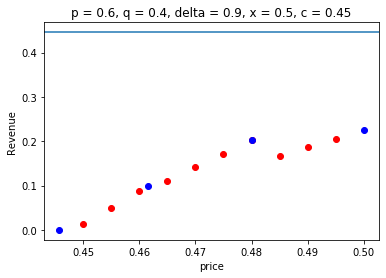

In [66]:
x = 0.5
p = 0.6
q = 0.4
# c = 0.40001
c2 = 0.45
delta = 0.9

# plot
# prices = getPossibleCX(x,p,q,c2)
prices = [0.45 + 0.005*i for i in range(10)]
profits = []
for i in range(len(prices)):
    ep = expected_profit(x,p,q,prices[i],c2,delta,100)
#     print(prices[i],ep)
    profits.append(ep)
    
plt.plot(prices,profits, 'ro')

prices = getPossibleCX(x,p,q,c2)
profits = []
for i in range(len(prices)):
    ep = expected_profit(x,p,q,prices[i],c2,delta,100)
#     print(prices[i],ep)
    profits.append(ep)

y = dynamic_profit(x,0.15,p,q,c2,delta)    
print(y)
print(max(profits))
    
plt.plot(prices,profits,'bo')
plt.xlabel('price')
plt.ylabel('Revenue')
plt.axhline(y=y,label='test')
# plt.text(10.1,0,'blah',rotation=90)
plt.title(f'p = {p}, q = {q}, delta = {delta}, x = {x}, c = {c2}')
plt.show()


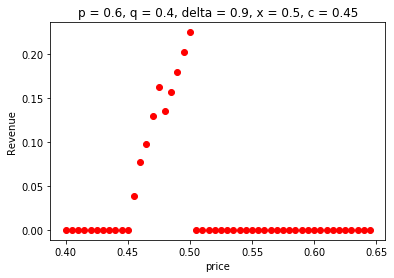

In [67]:
x = 0.5
p = 0.6
q = 0.4
# c = 0.40001
c2 = 0.45
delta = 0.9

# plot
# prices = getPossibleCX(x,p,q,c2)
prices = [0.4 + 0.005*i for i in range(50)]
profits = []
for i in range(len(prices)):
    ep = expected_profit_weighted(x,p,q,prices[i],c2,delta)
#     print(prices[i],ep)
    profits.append(ep)
    
plt.plot(prices,profits, 'ro')
plt.xlabel('price')
plt.ylabel('Revenue')
plt.title(f'p = {p}, q = {q}, delta = {delta}, x = {x}, c = {c2}')
plt.show()

In [62]:
# compute dynamic pricing
x = 0.5
x2 = 0.34
p,q = 0.6,0.4
c2 = 0.3
delta = 0.9


dynamic_profit(x,x2,p,q,c2,delta)

1.9999444562897841

In [86]:
def get_best_static_price(x,p,q,c2,delta):
    prices = getPossibleCX(x,p,q,c2)
    prior = None
    bestProfit = 0
    losses = None
    for i in range(len(prices)):
#         print(x,p,q,i,c2,delta,prices)
        ep,possibleLosses = expected_profit_rounds(x,p,q,prices[i],c2,delta)
#         print(prices[i],ep,possibleLosses)
        if ep >= bestProfit:
            prior = prices[i]
            bestProfit = ep
            losses = possibleLosses
    return prior, bestProfit, losses

def expected_profit_rounds(x,p,q,c,c2,delta,rounds=100):
    
    if c < c2 or local_reward(x,p,q,c) < 0:
        return 0,0
    tot = 0
    
    # first, get possible losses
    possibleLosses = 0
    x_new = x
    while local_reward(x_new,p,q,c) >= 0 and possibleLosses < 40:
        possibleLosses += 1
#         print(x_new, local_reward(x_new,p,q,c))
        x_new = update_prior(x_new,p,q,False)
    possibleLosses -= 1
    
    for t in range(rounds):
        lowest = max(0,int((t-possibleLosses+1)/2)-1)
            
        for w in range(lowest,t + 1,1):
            l = t - w
            paths = catTrapezoid(w,l,possibleLosses+1)
#             print(f"t: {t}, w: {w}, l: {l}, paths: {paths}")
            if paths > 0 or l == 0:
                tot += delta**t*(c - c2)*paths*prob_reach(x,w,l,p,q)
            elif paths == 0 and catTrapezoid(w,l-1,possibleLosses+1) > 0:
#                 print('got here')
                tot += delta**t*(win(x,p,q) - c2)*catTrapezoid(w,l-1,possibleLosses+1)*prob_reach(x,w,l-1,p,q)*lose(x_update(x,w,l-1,p,q),p,q)
                
    return tot, possibleLosses



In [119]:
x = 0.5
p = 0.6
q = 0.4
# c = 0.40001
# c2 = 0.45
delta = 0.9

production_prices = [0.4 + 0.005*i for i in range(20)]
revs = []
x_mins = []
for c2 in production_prices:
    x_min, rev, losses = get_best_static_price(x,p,q,c2,delta)
    revs.append(rev)
    
    for i in range(losses):
        x_min = update_prior(x_min,p,q,False)
    x_mins.append(x_min)
    
    print(c2,x,rev,x_min,losses)
    
print(production_prices,x_mins)

0.4 0.5 0.5276982376725389 0.38095238095238093 1
0.405 0.5 0.49520334029072627 0.38095238095238093 1
0.41000000000000003 0.5 0.4627084429089125 0.38095238095238093 1
0.41500000000000004 0.5 0.43021354552710195 0.38095238095238093 1
0.42000000000000004 0.5 0.39771864814529034 0.38095238095238093 1
0.42500000000000004 0.5 0.3652237507634763 0.38095238095238093 1
0.43000000000000005 0.5 0.33272885338166447 0.38095238095238093 1
0.43500000000000005 0.5 0.30023395599985137 0.38095238095238093 1
0.44 0.5 0.26974297630770594 0.5 0
0.445 0.5 0.2472643949487307 0.5 0
0.45 0.5 0.22478581358975527 0.5 0
0.455 0.5 0.20230723223078018 0.5 0
0.46 0.5 0.17982865087180386 0.5 0
0.465 0.5 0.15735006951282876 0.5 0
0.47000000000000003 0.5 0.1348714881538529 0.5 0
0.47500000000000003 0.5 0.11239290679487753 0.5 0
0.48000000000000004 0.5 0.08991432543590186 0.5 0
0.48500000000000004 0.5 0.06743574407692632 0.5 0
0.49 0.5 0.04495716271795101 0.5 0
0.495 0.5 0.022478581358975507 0.5 0
[0.4, 0.405, 0.4100000

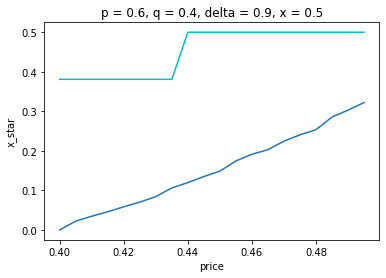

In [122]:
x_stars_dynamic = [0,0.0222,0.0346,0.046,0.05845,0.07025,0.0843,0.106075,0.119725,0.134925,
                   0.148725,0.1744875,0.1914375,0.2029,0.22465,0.2405375,0.253525,0.2855625,
                   0.30295,0.3222375]

plt.plot(production_prices,x_stars_dynamic)
plt.plot(production_prices,x_mins,'c')
plt.xlabel('price')
plt.ylabel('x_star')
plt.title(f'p = {p}, q = {q}, delta = {delta}, x = {x}')
plt.show()

In [126]:
play_forever_ratio = []
false_negative_ratio = []
for i in range(1,len(production_prices)):
    print(x,x_mins[i],x_stars_dynamic[i])
#     r = (x - x_mins[i])/((x - x_mins[i])*x)
#     play_forever_ratio.append(r)
    
    r2 = (1/x_stars_dynamic[i]-1)/(1/x_mins[i]-1)
    false_negative_ratio.append(r2)
    
print(play_forever_ratio)
print(false_negative_ratio)

0.5 0.38095238095238093 0.0222
0.5 0.38095238095238093 0.0346
0.5 0.38095238095238093 0.046
0.5 0.38095238095238093 0.05845
0.5 0.38095238095238093 0.07025
0.5 0.38095238095238093 0.0843
0.5 0.38095238095238093 0.106075
0.5 0.5 0.119725
0.5 0.5 0.134925
0.5 0.5 0.148725
0.5 0.5 0.1744875
0.5 0.5 0.1914375
0.5 0.5 0.2029
0.5 0.5 0.22465
0.5 0.5 0.2405375
0.5 0.5 0.253525
0.5 0.5 0.2855625
0.5 0.5 0.30295
0.5 0.5 0.3222375
[]
[27.104643104643102, 17.170297910182306, 12.762541806020067, 9.913009146542079, 8.144538735286066, 6.684551510174287, 5.186025852535398, 7.352474420547088, 6.411524921252548, 5.723819129265423, 4.731069560856795, 4.223636957231472, 3.9285362247412516, 3.4513687959047408, 3.157355921633841, 2.944384183019426, 2.5018603633180128, 2.300874731803928, 2.103301136584041]


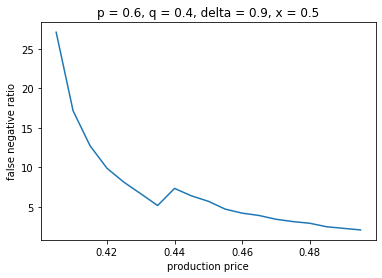

In [128]:
plt.plot(production_prices[1:],false_negative_ratio)
plt.xlabel('production price')
plt.ylabel('false negative ratio')
plt.title(f'p = {p}, q = {q}, delta = {delta}, x = {x}')
plt.show()

In [148]:
x = 0.5
p = 0.6
q = 0.4
# c = 0.40001
c2 = 0.45
delta = 0.9

priors = [c2 + 0.005*i for i in range(110)]
revs = []
x_mins = []
for x in priors:
    x_min, rev, losses = get_best_static_price(x,p,q,c2,delta)
    revs.append(rev)
    
    for i in range(losses):
        x_min = update_prior(x_min,p,q,False)
    x_mins.append(x_min)
    
    if x > 0.65: print(c2,x,rev,x_min,losses)
    
# print(priors,x_mins)

0.45 0.655 0.4335309308388203 0.4113110539845759 1
0.45 0.66 0.44187866867588665 0.41237113402061865 1
0.45 0.665 0.4502870547839895 0.41343669250646 1
0.45 0.67 0.4587564988661307 0.41450777202072536 1
0.45 0.675 0.4672874141496283 0.41558441558441556 1
0.45 0.68 0.4758802174241011 0.41666666666666674 1
0.45 0.685 0.4845353290799976 0.41775456919060056 1
0.45 0.69 0.4932531731473927 0.41884816753926696 1
0.45 0.6950000000000001 0.502034177335713 0.41994750656167973 1
0.45 0.7 0.5108787730735311 0.4210526315789474 1
0.45 0.7050000000000001 0.5197873955491515 0.4221635883905014 1
0.45 0.71 0.5287604837516453 0.42328042328042337 1
0.45 0.7150000000000001 0.5377984805124262 0.42440318302387275 1
0.45 0.72 0.5469018325474593 0.425531914893617 1
0.45 0.7250000000000001 0.5560709904997739 0.4266666666666667 1
0.45 0.73 0.5653064089829294 0.42780748663101603 1
0.45 0.7350000000000001 0.5746085466246887 0.42895442359249336 1
0.45 0.74 0.5839778661114656 0.43010752688172044 1
0.45 0.745 0.59341

0.9950000000000001 0.49000000000000005 0.148725
0.9950000000000001 0.491 0.148725
0.9950000000000001 0.49200000000000005 0.148725
0.9950000000000001 0.493 0.148725
0.9950000000000001 0.49400000000000005 0.148725
0.9950000000000001 0.495 0.148725
0.9950000000000001 0.496 0.148725
0.9950000000000001 0.497 0.148725
0.9950000000000001 0.498 0.148725
0.9950000000000001 0.499 0.148725
0.9950000000000001 0.5 0.148725
0.9950000000000001 0.501 0.148725
0.9950000000000001 0.502 0.148725
0.9950000000000001 0.503 0.148725
0.9950000000000001 0.504 0.148725
0.9950000000000001 0.505 0.148725
0.9950000000000001 0.506 0.148725
0.9950000000000001 0.507 0.148725
0.9950000000000001 0.508 0.148725
0.9950000000000001 0.509 0.148725
0.9950000000000001 0.51 0.148725
0.9950000000000001 0.511 0.148725
0.9950000000000001 0.512 0.148725
0.9950000000000001 0.39312039312039315 0.148725
0.9950000000000001 0.39408866995073893 0.148725
0.9950000000000001 0.39506172839506176 0.148725
0.9950000000000001 0.39603960396039

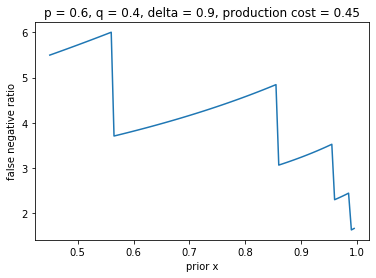

In [149]:
fixed_x_star = x_stars_dynamic[10]
false_negative_ratio = []
for i in range(len(priors)):
    print(x,x_mins[i],fixed_x_star)
#     r = (x - x_mins[i])/((x - x_mins[i])*x)
#     play_forever_ratio.append(r)
    
    r2 = (1/fixed_x_star-1)/(1/x_mins[i]-1)
    false_negative_ratio.append(r2)
    
print(false_negative_ratio)

plt.plot(priors,false_negative_ratio)
plt.xlabel('prior x')
plt.ylabel('false negative ratio')
plt.title(f'p = {p}, q = {q}, delta = {delta}, production cost = {c2}')
plt.show()